In [1]:
import os
import glob
import nilearn
import json
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import matplotlib.pyplot as plt
import datalad.api as dl

/Users/sunjaeshim/opt/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


### Access data from OpenNeuro

Let's start by grabbing the following data from OpenNeuro: https://openneuro.org/datasets/ds001734/versions/1.0.2

(Here is a data descriptor paper for this dataset where you can find details about the protocol and task: https://www.nature.com/articles/s41597-019-0113-7)

We can do this easily using datalad as the dataset is quite large. 

In [6]:
#you can see information about datalad.api or dl as we imported it by running the following command
help(dl)

Help on module datalad.api in datalad:

NAME
    datalad.api - Python DataLad API exposing user-oriented commands (also available via CLI)

DESCRIPTION
    
    *Essential*
    
      create
          Create a new dataset from scratch
      save
          Save the current state of a dataset
      status
          Report on the state of dataset content
      clone
          Obtain a dataset (copy) from a URL or local directory
      get
          Get any dataset content (files/directories/subdatasets)
      push
          Push a dataset to a known sibling
      run
          Run an arbitrary shell command and record its impact on a dataset
      diff
          Report differences between two states of a dataset (hierarchy)
    
    *Collaborative workflows*
    
      create_sibling_github
          Create dataset sibling on GitHub.org (or an enterprise deployment)
      create_sibling_gitlab
          Create dataset sibling at a GitLab site
      create_sibling_gogs
          Create a d

In [7]:
#Let's install the NARPS dataset from OpenNeuro
dl.install('https://github.com/OpenNeuroDatasets/ds001734.git')

[INFO] Attempting a clone into /Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734 
[INFO] Attempting to clone from https://github.com/OpenNeuroDatasets/ds001734.git to /Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734 
[INFO] Start enumerating objects 
[INFO] Start counting objects 
[INFO] Start compressing objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734) 
[INFO] Remote origin not usable by git-annex; setting annex-ignore 
[INFO] https://github.com/OpenNeuroDatasets/ds001734.git/config download failed: Not Found 
[INFO] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734" enable -s s3-PRIVATE 


install(ok): /Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734 (dataset)


Dataset('/Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734')

If you look at your directory, you will now find a folder called 'ds001734'.

Long story short, this is currently pointing at the data that is on git, but does not actually store the files on your local machine yet. We will have to download the files we want to use using dl.get()

But for now, we have data from OpenNeuro in BIDS format, including derivatives such as preprocessed images and confounds(fMRIPrep).
You can look around in the directory to see what files are in our dataset.

In [8]:
#I am going to set up some paths to make it easier for us to call our data later.
#You can make adjustments as necessary to point to the directory in your computer.
bids_dir = '/Users/sunjaeshim/Documents/GitHub/BrainHack2023_fMRI_practice/ds001734/'
fmriprep_dir = bids_dir + 'derivatives/fmriprep/'

#You can change the subjects you want to analyze.
some_subjects = ['sub-001']
#If you want to analyze all data, you can save all subject ids in this dataset by using glob
#Note this will take much much much longer and I wouldn't recommend running at the moment
all_files = glob.glob(bids_dir+'sub-*')
all_subjects = sorted([os.path.basename(i) for i in all_files])

### Defining functions

In python, we can define our own functions for things that we will use repeatedly.

For our GLM model, we will need event files, preprocessed images files, and confound files in order to build our design matrix. You can create a function to get the corresponding files. 

Note:
1. There are several runs per subject, so make sure you are organizing the correct files together.
2. Again, you will have to get the files from datalad. You can do this by running 'dl.get(filename)'
3. The default call for first_level_model has a built in function to compute a mask (so that you don't include skull etc. in your analysis). You may use other maskers you want if you want to skip the default computation of the mask by using fMRIPrep brain mask outputs or to specify regions of interest.


In [9]:
def get_files(sub, run):
    run = str(run)
    
    event_file = glob.glob(bids_dir+sub+f'/func/*run-0{run}*.tsv')[0]
    func_file = glob.glob(fmriprep_dir+sub+f'/func/*task-MGT*run-0{run}*preproc.nii.gz')[0]
    confounds_file = glob.glob(fmriprep_dir+sub+f'/func/*task-MGT*run-0{run}*confounds*')[0]
    
    #get files from datalad
    dl.get(event_file)
    dl.get(func_file) 
    dl.get(confounds_file)
    
    return event_file, func_file, confounds_file

We will also need to know the TR (repetition time) of the scans. 

You can get this information from the BIDS scan json file: https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/01-magnetic-resonance-imaging-data.html#required-fields

(A BIDS compliant dataset must always have the 'required' components)

In [16]:
#Let's take a look at the contents of the json file
json_file = glob.glob(bids_dir+'task-MGT_bold.json')[0]
f = open(json_file)
data = json.load(f)
print(data)

{'TaskName': 'MGT', 'Manufacturer': 'SIEMENS', 'ManufacturersModelName': 'Prisma', 'MagneticFieldStrength': 3, 'RepetitionTime': 1, 'EchoTime': 0.03, 'FlipAngle': 68, 'MultibandAccelerationFactor': 4, 'EffectiveEchoSpacing': 0.000275, 'SliceTiming': [0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625, 0, 0.4375, 0.875, 0.3125, 0.75, 0.1875, 0.625, 0.0625, 0.5, 0.9375, 0.375, 0.8125, 0.25, 0.6875, 0.125, 0.5625], 'BandwidthPerPixelPhaseEncode': 34.305, 'PhaseEncodingDirection': 'j-', 'TaskDescription': 'Mixed gambles task', 'CogAtlasID': 'http://www.cognitiveatlas.org/id/trm_4cacee4a1d875/'}


In [17]:
#Let's write a function that will return the TR value
def get_tr(bids_dir):
    json_file = glob.glob(bids_dir+'*bold.json')[0]
    f = open(json_file)
    data = json.load(f)
    tr = data['RepetitionTime']
    return tr

You can choose which confound regressors to add to the analysis. You can take a look at the confounds output to evaluate what you would include to denoise the scans. 

The very basic confounds most recommend are: 'FramewisesDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'.

The latter 6 are estimated head motion parameters as stored in this version of fMRIPrep outputs (note the names can be slightly different by version). 

More information about confound outputs from fMRIPrep: https://fmriprep.org/en/stable/outputs.html#confounds

In [11]:
#Let's write a function that returns a dataframe with the confound columns you would like to include in analysis
def get_confounds(confounds_file):
    confounds_df = pd.read_csv(confounds_file, sep='\t')
    #These are the very basic confounds most recommend. Adding the derivatives of these may also improve
    #Newer versions of fMRIPrep gives you derivatives
    #Note if you add CompCor components, you also should use the fMRIPrep cosine regressors instead of nilearn's
    confounds_df  = confounds_df[['FramewiseDisplacement', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']]
    
    return confounds_df

Now, let's think about which contrasts you would like to look at. You can set up definitions for difference contrasts that work with one or more regressors

In [25]:
def create_contrasts(design_matrix):
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)])
    contrasts = {
        'strongly accept - strongly reject': basic_contrasts['strongly_accept'] - basic_contrasts['strongly_reject'],
        'weakly accept - weakly reject': basic_contrasts['weakly_accept'] - basic_contrasts['weakly_reject'],
        'strongly accept - weakly accept': basic_contrasts['strongly_accept'] - basic_contrasts['weakly_accept'],
        'task - baseline': 1/4*(basic_contrasts['strongly_accept'] + basic_contrasts['strongly_reject'] + 
                                basic_contrasts['weakly_accept'] + basic_contrasts['weakly_reject'])
    }
    return contrasts

### Single run analysis
Now let's run the first level analysis of a single run of a single subject!

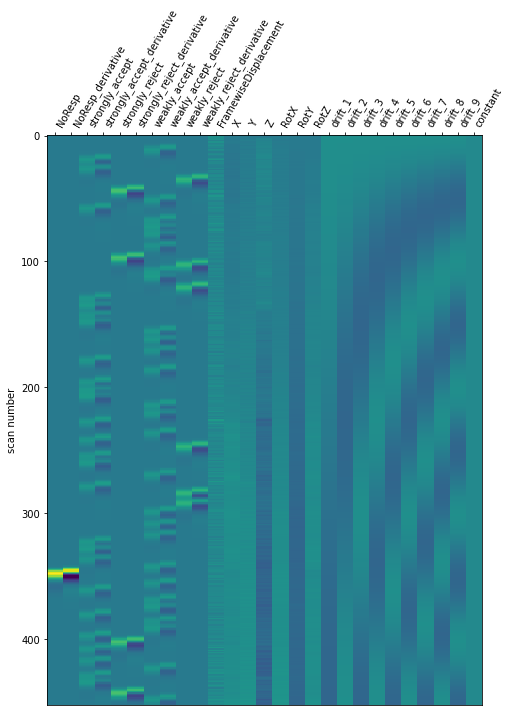

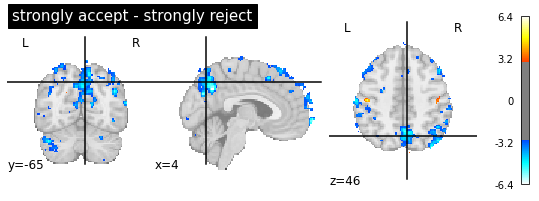

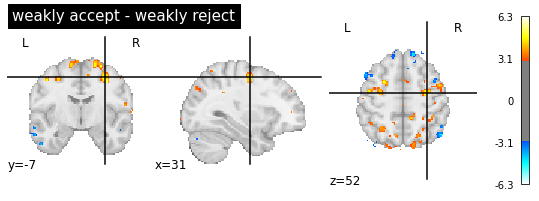

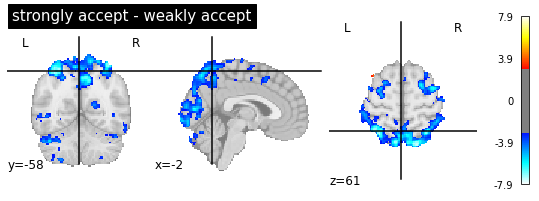

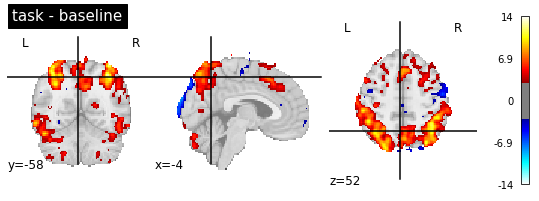

In [28]:
tr = get_tr(bids_dir)

event_file, func_file, confounds_file = get_files('sub-001', run=1)   
events = pd.read_csv(event_file, sep='\t')[['participant_response', 'onset', 'duration']]
events.rename(columns = {'participant_response':'trial_type'}, inplace=True)
confounds = get_confounds(confounds_file)
confounds = confounds.fillna(0)

#Fill in the following
first_level_model = FirstLevelModel(tr, hrf_model = 'spm + derivative', smoothing_fwhm=5)
first_level_model = first_level_model.fit(func_file, events=events, confounds=confounds)        
design_matrix = first_level_model.design_matrices_[0]

#show design matrix
plotting.plot_design_matrix(design_matrix)
plt.show()

#Call in contrasts
contrasts = create_contrasts(design_matrix)
#show contrast maps
for contrast_id, contrast_val in contrasts.items():
    z_map = first_level_model.compute_contrast(
            contrast_val, output_type = 'z_score'
            )
    plotting.plot_stat_map(
            z_map, threshold=3.0, title=contrast_id)
    plotting.show()

### Looping over multiple runs
We can use the same structure as the single run above to loop through multiple subjects and sessions

sub-001/ses-1


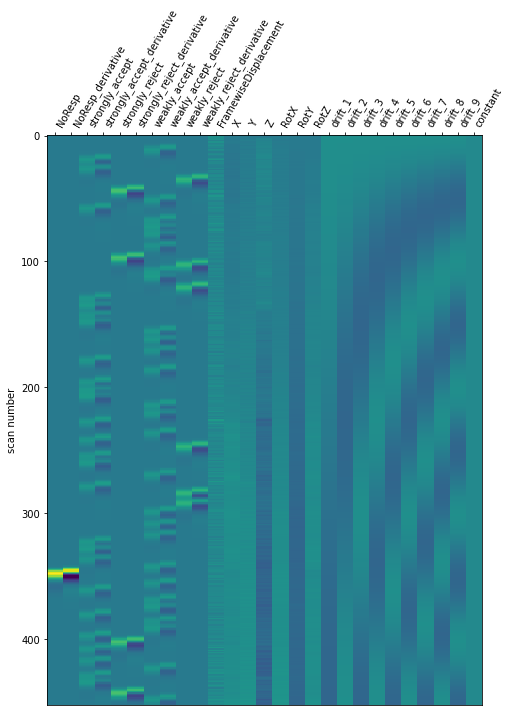

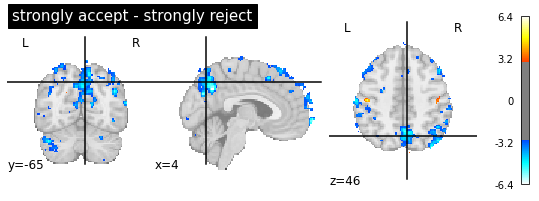

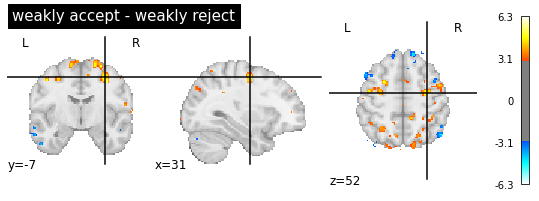

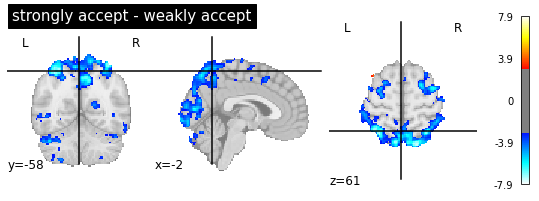

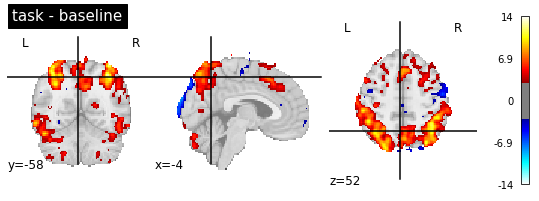

get(ok): ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz (file) [from s3-PUBLIC...]
sub-001/ses-2


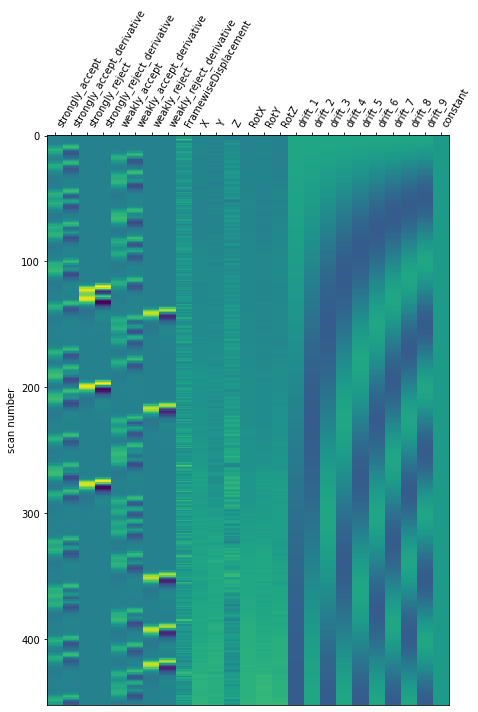

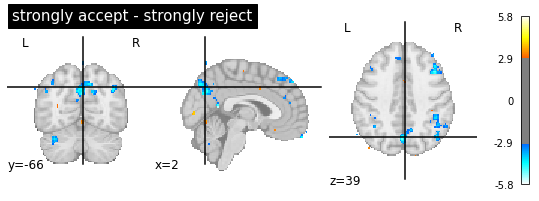

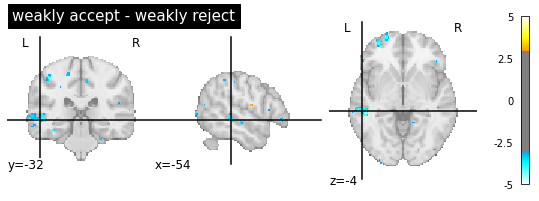

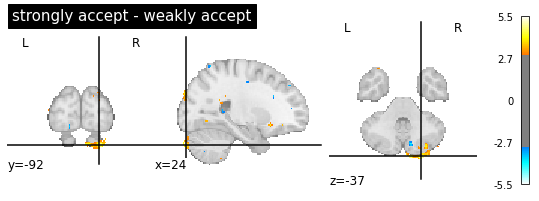

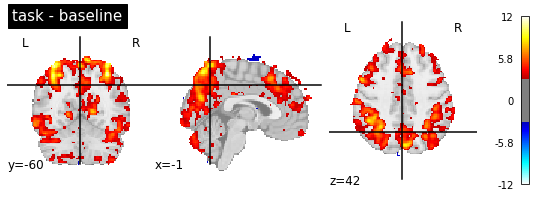

get(ok): ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii.gz (file) [from s3-PUBLIC...]
sub-001/ses-3


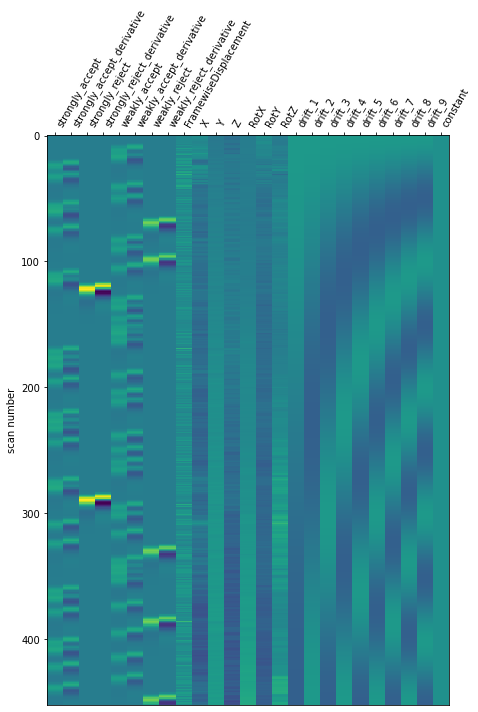

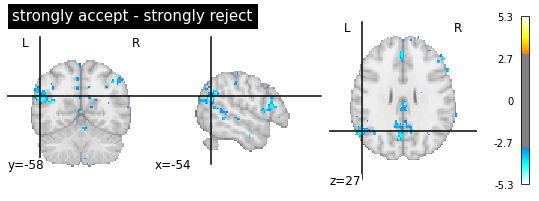

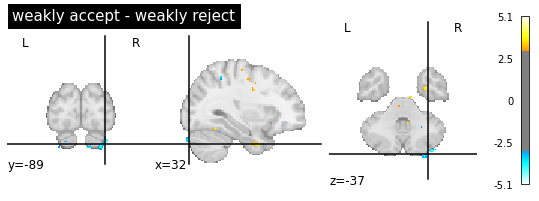

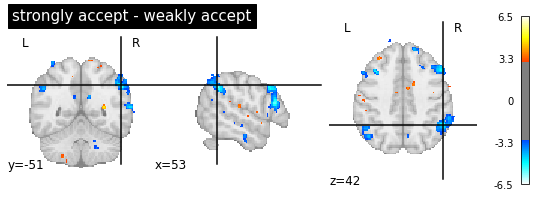

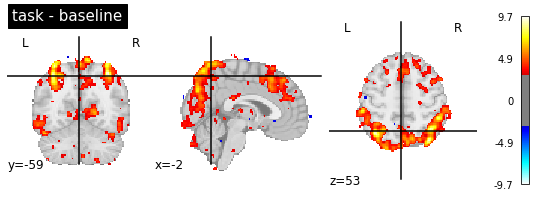

get(ok): ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-04_bold_space-MNI152NLin2009cAsym_preproc.nii.gz (file) [from s3-PUBLIC...]
sub-001/ses-4


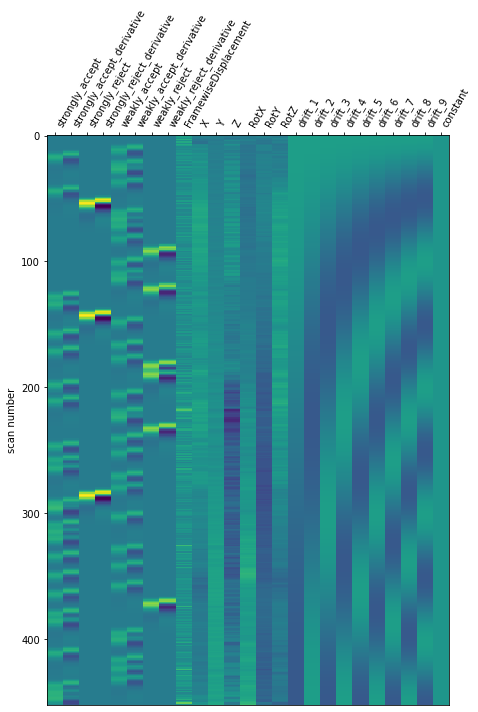

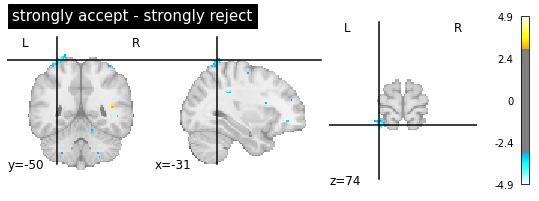

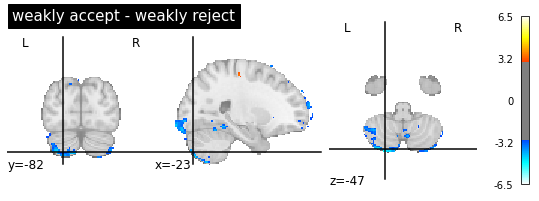

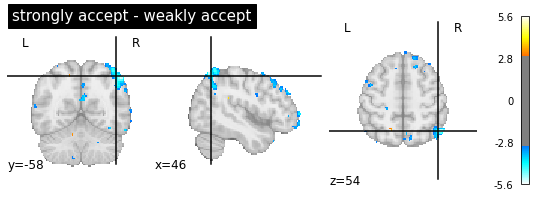

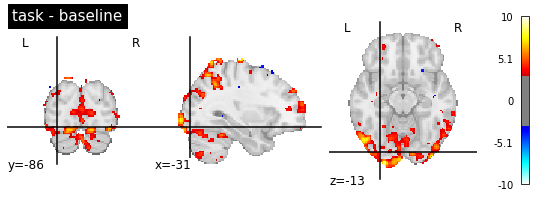

In [26]:
tr = get_tr(bids_dir)
for sub in some_subjects:
    for i in range(1,5):
        event_file, func_file, confounds_file = get_files(sub, i)        
        events = pd.read_csv(event_file, sep='\t')[['participant_response', 'onset', 'duration']]
        events.rename(columns = {'participant_response':'trial_type'}, inplace=True)
        confounds = get_confounds(confounds_file)
        confounds = confounds.fillna(0)
        first_level_model = FirstLevelModel(tr, hrf_model = 'spm + derivative', smoothing_fwhm=5)
        first_level_model = first_level_model.fit(func_file, events=events, confounds=confounds)        
        design_matrix = first_level_model.design_matrices_[0]
        #show design matrix
        print(f'{sub}/ses-{i}')
        plotting.plot_design_matrix(design_matrix)
        plt.show()
        
        contrasts = create_contrasts(design_matrix)
        #show contrast maps
        for contrast_id, contrast_val in contrasts.items():
            z_map = first_level_model.compute_contrast(
                    contrast_val, output_type = 'z_score'
                    )
            plotting.plot_stat_map(
                    z_map, threshold=3.0, title=contrast_id)
            plotting.show()